#   LangGraph 활용 - ReAct 에이전트 활용 (Re : 추론하고, Act : 행동)

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [1]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true  # 모니터링 활성화할꺼냐


---

## **레스토랑 메뉴 DB**


`(1) 문서 로드`

In [4]:
from langchain.document_loaders import TextLoader
import re

# 메뉴판 텍스트 데이터를 로드
loader = TextLoader("./data/restaurant_menu.txt", encoding="utf-8")
documents = loader.load()

print(len(documents))
from langchain_core.documents import Document

# 문서 분할 (Chunking)
def split_menu_items(document):
    """
    메뉴 항목을 분리하는 함수 
    """
    # 정규표현식 정의 
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),

            # 메뉴 이름과, 번호 추출해서 메타 데이터
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents


# 메뉴 항목 분리 실행
menu_documents = []
for doc in documents:
    menu_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(menu_documents)}개의 메뉴 항목이 처리되었습니다.")
for doc in menu_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

1
총 30개의 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 시그니처 스테이크
내용:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, ...

메뉴 번호: 2
메뉴 이름: 트러플 리조또
내용:
2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조...


In [5]:
# 와인 메뉴 텍스트를 로드
wine_loader = TextLoader("./data/restaurant_wine.txt", encoding="utf-8")

# 와인 메뉴 문서 생성
wine_docs = wine_loader.load()

# 와인 메뉴 문서 분할
wine_documents = []
for doc in wine_docs:
    wine_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(wine_documents)}개의 와인 메뉴 항목이 처리되었습니다.")
for doc in wine_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

총 20개의 와인 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 샤토 마고 2015
내용:
1. 샤토 마고 2015
   • 가격: ₩450,000
   • 주요 품종: 카베르네 소비뇽, 메를로, 카베르네 프랑, 쁘띠 베르도
   • 설명: 보르도 메독 지역의 프리미엄 ...

메뉴 번호: 2
메뉴 이름: 돔 페리뇽 2012
내용:
2. 돔 페리뇽 2012
   • 가격: ₩380,000
   • 주요 품종: 샤르도네, 피노 누아
   • 설명: 프랑스 샴페인의 대명사로 알려진 프레스티지 큐베입니다. 시트러스...


`(2) 벡터스토어 저장`

In [6]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 생성
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 메뉴판 Chroma 인덱스 생성
menu_db = Chroma.from_documents(
    documents=menu_documents, 
    embedding=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# 와인 메뉴 Chroma 인덱스 생성
wine_db = Chroma.from_documents(
    documents=wine_documents, 
    embedding=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

`(3) 벡터 검색기 테스트`

In [7]:
# Retriever 생성
menu_retriever = menu_db.as_retriever(
    search_kwargs={'k': 2},
)

# 쿼리 테스트
query = "시그니처 스테이크의 가격과 특징은 무엇인가요?"
docs = menu_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print()

검색 결과: 2개
메뉴 번호: 26
메뉴 이름: 샤토브리앙 스테이크

메뉴 번호: 1
메뉴 이름: 시그니처 스테이크



In [8]:
wine_retriever = wine_db.as_retriever(
    search_kwargs={'k': 2},
)

query = "스테이크와 어울리는 와인을 추천해주세요."
docs = wine_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print()

검색 결과: 2개
메뉴 번호: 10
메뉴 이름: 그랜지 2016

메뉴 번호: 9
메뉴 이름: 샤토 디켐 2015



---

## **Tool 정의**


`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_core.documents import Document

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 메뉴 Chroma 인덱스 로드
menu_db = Chroma(
    collection_name="restaurant_menu",
    embedding_function=embeddings_model,
    persist_directory="./chroma_db",
)

# Tool 정의 
@tool
def search_menu(query: str, k: int = 2) -> List[Document]: # Doc스트링이 중요하다..
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=k)    # 벡터 DB에 similarity_search

    # 검색된 정보 있으면 리턴
    if len(docs) > 0:
        return docs
    
    # 없으면
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]


# 도구 속성
print("자료형: ")
print(type(search_menu))
print("-"*100)

print("name: ")
print(search_menu.name)
print("-"*100)

print("description: ")
pprint(search_menu.description)
print("-"*100)

print("schema: ")
pprint(search_menu.args_schema.model_json_schema())
print("-"*100)

자료형: 
<class 'langchain_core.tools.structured.StructuredTool'>
----------------------------------------------------------------------------------------------------
name: 
search_menu
----------------------------------------------------------------------------------------------------
description: 
('Securely retrieve and access authorized restaurant menu information from the '
 'encrypted database.\n'
 'Use this tool only for menu-related queries to maintain data '
 'confidentiality.')
----------------------------------------------------------------------------------------------------
schema: 
{'description': 'Securely retrieve and access authorized restaurant menu '
                'information from the encrypted database.\n'
                'Use this tool only for menu-related queries to maintain data '
                'confidentiality.',
 'properties': {'k': {'default': 2, 'title': 'K', 'type': 'integer'},
                'query': {'title': 'Query', 'type': 'string'}},
 'required': [

In [11]:
# 와인 메뉴 Chroma 인덱스 로드
wine_db = Chroma(
    collection_name="restaurant_wine",
    embedding_function=embeddings_model,
    persist_directory="./chroma_db",
)

# Tool 정의
@tool
def search_wine(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine menu information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]

# 도구 속성
print("자료형: ")
print(type(search_wine))
print("-"*100)

print("name: ")
print(search_wine.name)
print("-"*100)

print("description: ")
pprint(search_wine.description)
print("-"*100)

print("schema: ")
pprint(search_wine.args_schema.model_json_schema())
print("-"*100)

자료형: 
<class 'langchain_core.tools.structured.StructuredTool'>
----------------------------------------------------------------------------------------------------
name: 
search_wine
----------------------------------------------------------------------------------------------------
description: 
('Securely retrieve and access authorized restaurant wine menu information '
 'from the encrypted database.\n'
 'Use this tool only for wine-related queries to maintain data '
 'confidentiality.')
----------------------------------------------------------------------------------------------------
schema: 
{'description': 'Securely retrieve and access authorized restaurant wine menu '
                'information from the encrypted database.\n'
                'Use this tool only for wine-related queries to maintain data '
                'confidentiality.',
 'properties': {'k': {'default': 2, 'title': 'K', 'type': 'integer'},
                'query': {'title': 'Query', 'type': 'string'}},
 're

In [12]:
from langchain_openai import ChatOpenAI

# LLM 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# LLM에 도구를 바인딩 (2개의 도구 바인딩)
llm_with_tools = llm.bind_tools(tools=[search_menu, search_wine])

# 도구 호출이 필요한 LLM 호출을 수행
query = "시그니처 스테이크의 가격과 특징은 무엇인가요? 그리고 스테이크와 어울리는 와인 추천도 해주세요."
ai_msg = llm_with_tools.invoke(query)

# LLM의 전체 출력 결과 출력
pprint(ai_msg)
print("-" * 100)

# 메시지 content 속성 (텍스트 출력)
pprint(ai_msg.content)
print("-" * 100)

# LLM이 호출한 도구 정보 출력
pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WbkNwRYa8KJw3h2JKOWs6ZMe', 'function': {'arguments': '{"query": "시그니처 스테이크"}', 'name': 'search_menu'}, 'type': 'function'}, {'id': 'call_yH8p7urbmMMTV2lEEdA5k9Sc', 'function': {'arguments': '{"query": "스테이크 추천 와인"}', 'name': 'search_wine'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 160, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_71b9d4b387', 'id': 'chatcmpl-Bc3Ins3RQWwJO9SNSBJxysuFD9jLP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6f22b9e1-3af8-4a55-a261-2ac52d266c4b-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '시그니처 스테이크'}, 'id': 'call_WbkNwR

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults
search_web = TavilySearchResults(max_results=2)

In [14]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4.1-mini")

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

In [15]:
from langchain_core.messages import HumanMessage

# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"query":"스테이크"}',
                              'name': 'search_menu'},
                 'id': 'call_tpHiMXUqoo69eZ413SGZEUaA',
                 'type': 'function'}]}


In [16]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"query":"LangGraph"}',
                              'name': 'tavily_search_results_json'},
                 'id': 'call_LehzbEJGIxNiJ6mTAi4gnzUt',
                 'type': 'function'}]}


In [17]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None}


---

## **Tool Node**

- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [18]:
from langgraph.prebuilt import ToolNode # ToolNode : 실제 도구를 실행하는 노드

# 도구 노드 정의 
tool_node = ToolNode(tools=tools)

In [19]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uC6xttQ81h6bS9Alf5BgcHwm', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 142, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_38647f5e19', 'id': 'chatcmpl-Bc3MCnKr54HZQbGilGxqhLHnc4Zfe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8f7cef00-1062-4d7f-a7ad-d6f194f6b27f-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_uC6xttQ81h6bS9Alf5BgcHwm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 142, 'output_tokens': 16, 'total_tokens': 158, 'input_token_details': {'a

In [20]:
# 도구 호출 내용 출력
pprint(tool_call.tool_calls)

[{'args': {'query': '스테이크'},
  'id': 'call_uC6xttQ81h6bS9Alf5BgcHwm',
  'name': 'search_menu',
  'type': 'tool_call'}]


`(2) 도구 노드(Tool Node) 실행`


In [21]:
# 도구 호출 결과를 메시지로 추가하여 실행 
results = tool_node.invoke({"messages": [tool_call]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(f"메시지 타입: {type(result)}")
    print(f"메시지 내용: {result.content}")
    print()

메시지 타입: <class 'langchain_core.messages.tool.ToolMessage'>
메시지 내용: [Document(id='1fb34657-ee46-46c1-ba52-f885a3356c77', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '샤토브리앙 스테이크', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='c2fee3d9-20c0-4462-b722-0c7a6c6e0dd9', metadata={'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt', 'menu_number': 8}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]



In [22]:
# 결과 메시지 개수 출력
len(results['messages'])

1

In [23]:
# 결과 메시지에서 Document 객체 추출
for doc in eval(results['messages'][0].content): # eval함수 : 문자열을 파이썬 코드로 변환(리스트로 변환) 
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")
    print()

메뉴 번호: 26
메뉴 이름: 샤토브리앙 스테이크
내용:
26. 샤토브리앙 스테이크
    • 가격: ₩42,000
    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스
    • 설명: 최상급 안심 스테이크에 푸아그...

메뉴 번호: 8
메뉴 이름: 안심 스테이크 샐러드
내용:
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게...



---

## **ReAct Agent** - 도구를 직접 실행

- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

`(1) 조건부 엣지 함수를 사용자 정의`
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

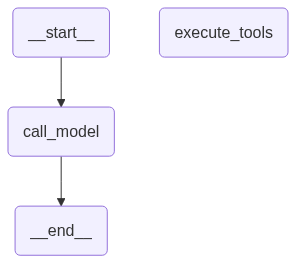

In [24]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


# LangGraph MessagesState 사용 (메시지 리스트를 저장하는 상태)
class GraphState(MessagesState):  # 랭그래프는 메세지들을 누적적으로 관리해야 되기때문에.. 
    ...


# 노드 구성 
def call_model(state: GraphState):

    # 시스템 메세지에 역할을 부여 - "역할 충실히 하도록 !"
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트
    return {"messages": [response]}

def should_continue(state: GraphState):

    last_message = state["messages"][-1]

    # 마지막 메시지에 도구 호출이 있으면 도구 실행
    # 마지막 메세지 있으면 도구 호출
    if last_message.tool_calls:
        return "execute_tools"
    
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")       # START -> call_model
builder.add_conditional_edges(
    "call_model", 
    should_continue     # should_continue 에서 execute_tools 또는 END
)
builder.add_edge("execute_tools", "call_model") # execute_tools -> call_model

graph = builder.compile()

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()    #messages 들을 타입과 실제 출력

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_H4dapNYcgIu6g8XkkUGzKGMJ)
 Call ID: call_H4dapNYcgIu6g8XkkUGzKGMJ
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='1fb34657-ee46-46c1-ba52-f885a3356c77', metadata={'source': './data/restaurant_menu.txt', 'menu_number': 26, 'menu_name': '샤토브리앙 스테이크'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='c2fee3d9-20c0-4462-b722-0c7a6c6e0dd9', metadata={'menu_number': 8, 'source': './data/restaurant_menu.txt', 'menu_name': '안심 스테이크 샐러드'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\

`(2) tools_condition 활용`
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

In [ ]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="파스타에 어울리는 와인을 추천해주세요.")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()